# Snowfall Retrievals CSU X-Band Radar March 14, 2022
Let's take a look at precipitation from an event on March 14, 2022 as a part of the SAIL field campaign.

## Imports

In [17]:
import glob
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pyart
import xarray as xr
from matplotlib.dates import DateFormatter
import pandas as pd

## Setup Helper Functions

In [11]:
def snow_rate(radar, SWE_ratio, A, B):
    """
    Takes a given Snow Water Equivilent ratio (SWE_ratio), A and B value
    for the Z-S relationship and creates a radar field similar to DBZ
    showing the radar estimated snowfall rate in mm/hr. Then the given
    SWE_ratio, A and B are stored in the radar metadata for later 
    reference.   

    """
    # Setting up for Z-S relationship:
    snow_z = radar.fields['DBZ']['data'].copy()
    # Convert it from dB to linear units
    z_lin = 10.0**(radar.fields['DBZ']['data']/10.)
    # Apply the Z-S relation.
    snow_z = SWE_ratio * (z_lin/A)**(1./B)
    # Add the field back to the radar. Use reflectivity as a template
    radar.add_field_like('DBZ', 'snow_z',  snow_z,
                         replace_existing=True)
    # Update units and metadata
    radar.fields['snow_z']['units'] = 'mm/h'
    radar.fields['snow_z']['standard_name'] = 'snowfall_rate'
    radar.fields['snow_z']['long_name'] = 'snowfall_rate_from_z'
    radar.fields['snow_z']['valid_min'] = 0
    radar.fields['snow_z']['valid_max'] = 500
    radar.fields['snow_z']['swe_ratio'] = SWE_ratio
    radar.fields['snow_z']['A'] = A
    radar.fields['snow_z']['B'] = B
    return radar

## Define the Point Retrievals
We need to create a set of latitude and longitude values for the different instrumentation locations.

In [56]:
# Define the splash locations [lon,lat]
sail = [-106.987, 38.9586]
kettle_ponds = [-106.9731488, 38.9415427]
brush_creek = [-106.920259, 38.8596282]
avery_point = [-106.9965928, 38.9705885]
pumphouse_site = [-106.9502476, 38.9226741]
roaring_judy = [-106.8530215, 38.7170576]

# Zip these together!
lons, lats = list(zip(sail,
                      kettle_ponds,
                      brush_creek,
                      avery_point,
                      pumphouse_site,
                      roaring_judy))

## List the Available Files
We will use files on the Oak Ridge Laboratory Computing Facility (ORLCF), within the shared SAIL directory `/gpfs/wolf/atm124/proj-shared/sail`.

These radar files have been merged from a single sweep in each file, to whole volume scans in each file.

In [55]:
file_list = sorted(glob.glob("/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314*"))
file_list[:10]

['/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-000239.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-000759.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-001319.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-001839.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-002359.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-002919.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-003439.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-003959.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-004519.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-005039.b1.nc']

## Read Data + Subset at Points
We do not need every time point for a first look - we can resample to every fifth, and apply our snowfall rate.

In [51]:
ds_all = []
ds_base = []
for file in file_list[::5]:
    radar = pyart.io.read(file)
    #-------------------------------------------------------------------------
    # Add in the extra fields to the radar object before extracting the column
    #-------------------------------------------------------------------------
    # Calculate estimated rainfall rate from reflectivty
    #rain = pyart.retrieve.qpe.est_rain_rate_z(radar)
    # Add the estimated rainfall rate back into the radar object
    #radar.add_field('est_rainfall_rate', rain)
    # Call Matt's Z-S function with the constants he used
    radar = snow_rate(radar, 8.5, 28, 1.44)
    #-------------------------------------------------------------------------
    column = pyart.util.columnsect.get_field_location(radar, avery_point[1], avery_point[0])
    # Add a datetime dimension to the xarray radar column
    dt = pd.to_datetime(radar.time["data"], unit='s')[-1]
    coor_ad = column.assign_coords(date=dt.timestamp())
    ncolumn = coor_ad.expand_dims('date')
    # Make sure there are no duplicate height indices
    index = np.unique(column['height'], return_index=True)
    ncolumn = ncolumn.isel(height=index[1])
    basecolumn = ncolumn.isel(height=index[1][0])
    # append to the xarray dataset list
    ds_all.append(ncolumn)
    ds_base.append(basecolumn)
    print(file)

/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-000239.b1.nc
/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-002919.b1.nc
/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-005559.b1.nc
/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-012239.b1.nc
/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-014919.b1.nc
/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-021559.b1.nc
/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-024239.b1.nc
/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-030920.b1.nc
/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-033600.b1.nc
/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-040240.b1.nc
/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar

### Merge our Datasets
Our datasets are separate for now, we need to merge them using Xarray!

In [52]:
# combine the xarry DataArrays
ds_height = xr.concat(ds_all, 'date')
ds = xr.concat(ds_base, 'date')

### Correct the Times
We need to convert the times to datetime instead of integer values

In [53]:
ds_height["date"] = pd.to_datetime(ds_height.date.values, unit='s')
ds["date"] = pd.to_datetime(ds.date.values, unit='s')

## Visualize the Output
We can use a combination of default plotting functions from Xarray, as well as some custom styling.

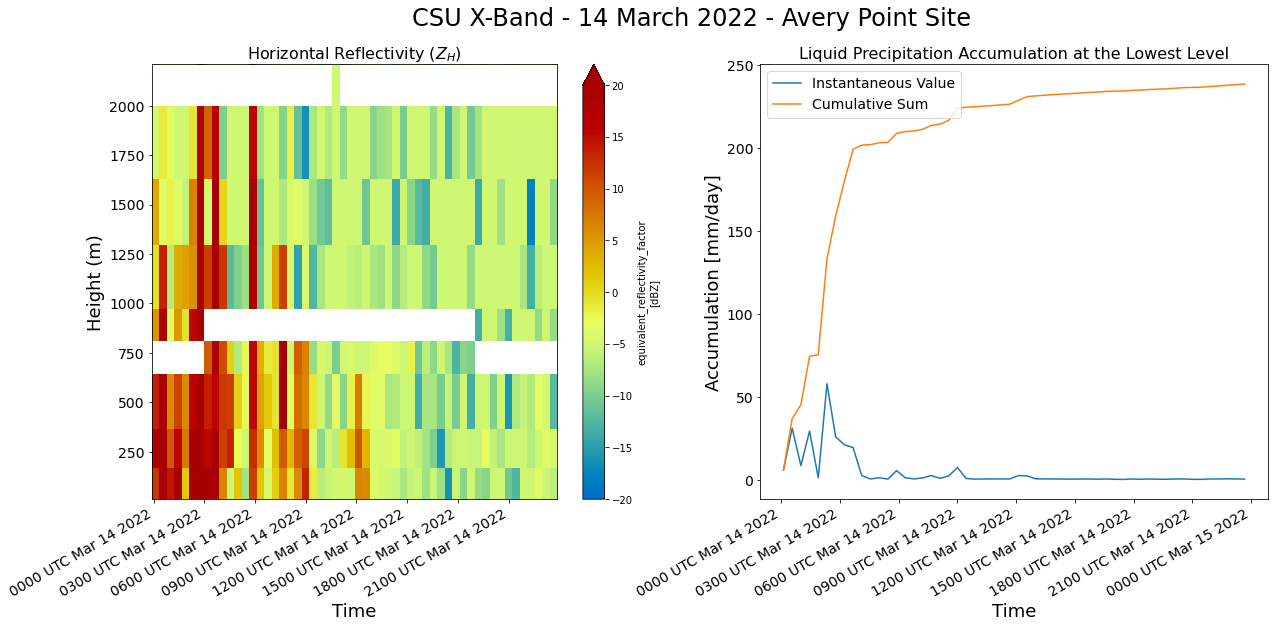

In [58]:
fig = plt.figure(figsize=(20,8))

# Define the date format
date_form = DateFormatter("%H%M UTC %b %d %Y")

# Setup the first axis
ax = plt.subplot(121)
plot = ds_height.DBZ.plot(x='date',
                          cmap='pyart_HomeyerRainbow',
                          vmin=-20,
                          vmax=20,
                          ax=ax)

# Apply the date formatter to the first axis
ax.xaxis.set_major_formatter(date_form)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Height (m)", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.title("Horizontal Reflectivity ($Z_{H}$)",
          fontsize=16)

# Setup the second axis
ax2 = plt.subplot(122)
ds.snow_z.plot(x='date',
               label='Instantaneous Value',
               ax=ax2)

ds.snow_z.cumsum().plot(x='date',
                        label='Cumulative Sum',
                        ax=ax2)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Accumulation [mm/day]", fontsize=18)
plt.xlabel("Time", fontsize=18)
plt.title("")

# Apply the date formatter to the second
ax2.xaxis.set_major_formatter(date_form)
plt.title("Liquid Precipitation Accumulation at the Lowest Level",
          fontsize=16)
plt.legend(fontsize=14,
           loc='upper left')

plt.suptitle("CSU X-Band - 14 March 2022 - Avery Point Site", fontsize=24);